**This code computes the decomposed solution of a Closed-Loop DRTO problem and compares it with the monolithic solution.**


- The case study is a two nonlinear reactors in parallel from:*2018, Economic Coordination of Distributed Nonlinear MPC Systems using Closed-loop Prediction of a Nonlinear Dynamic Plant, H Li and C L E Swartz* 
- The underlying control structure (modeled in the CLDRTO model) contains two unconstrained MPC, which are represented by their KKT conditions in the DRTO problem. 
- The problem is posed as a scenario-based stochastic programming problem
- The uncertainty represented by the scenarios comes from the the heat transfer coefficient (UA) 

--> see jupyter notebook "Preliminaries" for details

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: August 2023

[1.Model and Simulation Parameters](#sec1) <br>
[2.Building Auxiliary Functions](#sec2)<br>
[2.1. MPC matrices builder](#subsec21)<br>
[2.2. Monolithic CLDRTO](#subsec22)<br>
[2.3. Decomposed CLDRTO](#subsec23)<br>
[3. Comparing performance when # of scenarios increase](#sec3)<br>
[4. Comparing trajectories computed by monolhitic and decomposed](#sec4)<br>

In [1]:
using LinearAlgebra, JuMP, Ipopt, Plots, DataFrames

<a id="sec1"></a>

# Model and Simulation Parameters

- Simulation Parameters

In [2]:
# Simulation sampling time
dt = 0.5 #[s]

# Optimization horizon 
ndrto = 20 # dt_DRTO

# time series for plotting
t_drto = Vector{Float64}(undef,ndrto) 
for kk in 1:ndrto
    t_drto[kk] = dt*kk
end

# number of components
nc = 3 #[-]
# number of inputs
nu = 2 #[-]
# number of reactors
nrt = 2 #[-]
# number of reactions
nrc = 2 #[-]
# number of MPCs
numpc = 2 

# initial value
C0 = [0.124287 0.216517;
    19.725 19.659;
    0.150668 0.124504]
T0 = [341.7216268417903 331.0792925101132]

# "algebraic states"
C_in0 = [20.0 10.0621;
          0 9.86252;
          0 0.0753341]
T_in0 = [299.99999999998846 320.8608134932841]
Tj_out0 = [316.6886507367161 297.43171700404525]

# "inputs"
Q0 = 0.2
Qm0 = 0.2

# initial value of u
u0 = [Q0 Qm0];

- Model Parameters

In [3]:
# feed to reactor 1 concentrations c = (A,B,C)
C1_in = [20.0, 0, 0] #[kmol/m3]

# temperature of feed to reactor 1
T1_in = 300.0 #[K]

# feed to mixer concentration c = (A,B,C)
Cm_in = [20.0, 0, 0]

# temperature of feed to mixer
Tm_in = 300.0 #[K]

# feed flowrate of cooling water to reactor jacket r = (1,2)
Qj_in = [0.7, 0.7] #[m3/s]

# cooling water temperature to reactor jacket r = (1,2)
Tj_in = [300.0, 275.0] #[m3/s]

# reactor volumetric holdup r = (1,2)
V = [5.0, 5.0] #[m3]

# heat transfer coefficient
Ua = [0.35, 0.35] #[m3/s]

# reaction rate constant e = (I,II)
k0 = [2.7e8, 160.0] #[1/s]

# reaction activation energy e = (I,II)
ER = [6000.0, 4500.0] #[K]

# heat of reaction e = (I,II)
dH_pcp = -[5.0, 5.0] #[m3 K/kmol] 

# stochiometric matrix 
Ms = [-1 0;
       1 -1;
       0 1];

In [4]:
# Uncertain parameters: Ua1 
# nominal value
pNom = 0.35
# standard deviation associated with uncertainty
deltaPar = 0.01*0.007; 

- Economic Optimization Problem Parameters

In [5]:
# feed supply limitation
Qf_max = 0.8 #[m3/s] 

# safety restriction (avoiding temperature run away)
Tr_max = 350 #[K]

# product specifications
cA2_max = 0.3 #[kmol/m3]

# max cooling water outlet temperature r = (1,2)
Tj_max = [330, 300] #[K]

# min feed to reactor 1
Q_min = 0.05 #[m3/s]

# min feed to mixer
Qm_min = 0.05; #[m3/s]

# Output bounds (T1, T2)
yMin = [100.0 100.0] #K
yMax = [350.0 350.0] #K

# Setpoint bounds (T1, T2)
yspMin = [100.0 100.0] #K
yspMax = [360.0 360.0] #K

# Input bounds (Q1, Qm)
uMin = [0.050 0.050] #K
uMax = [0.805 0.800]; #K

- Steady-state optimal solution

In [6]:
# concentration related variables
C0_star = [0.114545 0.174342;
    19.7379 19.6938;
    0.147529 0.13187]

T0_star = [350.00000000404816 337.5000000227455]
T_in0_star = [300.0 327.5923855099112]
Tj_out0_star = [320.00000000161924 300.0000000090982]
Q0_star = [0.27907949788513375 0.5057183218310063]
Qm0_star = 0.22663882394587254

solSS = Dict('C' => C0_star,
             'T' => T0_star,
             'I' => T_in0_star, 
             'J' => Tj_out0_star,
             'Q' => Q0_star,
             'M' => Qm0_star);

- MPC Parameters
MPC1: reactor 1 (Q1 <-> T1) <br>
MPC2: reactor 2 (Qm <-> T2)

In [7]:
##########
# MODELS #
##########
# reference for deviation variables
# MPC 1
T1_0_bar = 350.00000000404816
Q1_0_bar = 0.27907949788513375

# MPC 2
T2_0_bar = 337.5000000227455
Qm_0_bar = 0.22663882394587254

yref = [T1_0_bar T2_0_bar]
uref = [Q1_0_bar Qm_0_bar]

# Linear SISO model coefficients
# MPC1
a1_hat = 0.9444968979045645
b1_hat = 4.755754997301486

# MPC2
a2_hat = 0.9256356006985642
b2_hat = 5.70696857693315

# initial value of xMPC
xMPC0 = [T0[1] - T1_0_bar, T0[2] - T2_0_bar]

##########
# TUNING #
##########
# prediction horizon 
p = 5

# control horizon 
m = 3

# output tracking weight
q = 1

# move supression weight
r = [150,500]

# input bounds
u_mpc_lb = 0.050
u_mpc_ub = 0.805

##################
# KKT CONDITIONS #
##################
# matrix to compute the gradients of the input bound constraints
conMatrix = [-I(m); I(m)]

# Regularized FB function 
epsFB = [1e-6 1e-6 1e-6 1e-6 1e-6 1e-6];

- Preparing Orthogonal Collocation

In [8]:
# Parameters for orthogonal collocation
#  Radau Collocation Points 1st degree polynomial == Backward Euler
radau  = [0.0 1.00000]

# number of collocation points (initial point is also considered)
ncp = length(radau) 

# Collocation parameters and radau time series
colmat = [-1.0 -1.0;
          1.0 1.0]

# length of one finite element on the time horizon
h = dt;          

- Bender's Decomposition

In [9]:
# max number of iteration
benIterMax = 50

# optimality gap (relative) tolerance
optGap = 1e-3; # UNC/BIN: 0.001 | MPCC: 0.5

<a id="sec2"></a>

# Building auxiliary functions

<a id="subsec21"></a>

## MPC matrices builder

In [10]:
function MPC_matrices(A,B,C,p,m,q,r)
    ###########
    # inputs: #
    ###########
    # A,B,C - System model
    # p, m - prediction and control horizon
    # q, r - setpoint and input usage tuning parameters
    
    # extracting dimensions from system model
    nx = size(A,1) # states
    nu = size(B,2) # inputs
    ny = size(C,1) # outputs
    
    # adding disturbance model
    Ad = [A zeros(nx,ny); zeros(ny,nx) I(ny)]
    Bd = [B; zeros(ny,nu)]
    Cd = [C ones(ny,ny)]
    
    # building matrices for MPC
    Psi = Cd*Ad
    for ii in 2:p
        Psi = [Psi;  Cd*Ad^ii]
    end

    # Computing Dynamic Matrix
    a = Cd*Bd
    for ii in 2:p
        a = [a; Cd*Ad^(ii - 1)*Bd]
    end
    DynM = a

    for ii in 1:(m - 2)
        a = [zeros(ny,nu);a[1:(p-1)*ny,:]]
        DynM = [DynM  a]
    end

    # adjusting dynamic matrix for since p > m (last column)
    b = Cd*Bd

    Ai = I(nx+1) # adding disturbance to the states
    for ii = 1:(p - m)
        Ai = Ai + Ad^ii
        b = [b;Cd*Ai*Bd]
    end

    Theta=[DynM [zeros(ny*(m-1),nu);b]]
    
    # Creating Qbar and Rbar matrices
    Qbar = Diagonal([q for ii in 1:p])
    Rbar = Diagonal([r for ii in 1:m])

    # Creating input movement OF penalty matrix 
    M=[zeros((m-1)*nu,nu) I(nu*(m-1)); zeros(nu) zeros(nu,nu*(m-1))]
    Ibar=[I(nu); zeros(nu*(m-1),nu)]
    IM = I(nu*m) - M';
    
    # Matrix H
    H = Theta'*Qbar*Theta + IM'*Rbar*IM;
    
    return Dict('A' => A, 'B' => B, 'C' => C, 'H' => H, 'Θ' => Theta, 'Ψ' => Psi, 'Q' => Qbar, 'I' => Ibar, 'R' => Rbar, 'M' => IM)
end;

<a id="subsec22"></a>

## Monolithic solution of scenario-based CLDRTO

In [11]:
function MS_CLDRTO(C0,T0,u0,xMPC0,UaTemp,ns,solNom)
    ###########
    # inputs: #
    ###########
    # C0, T0 - concentration and temperature states at the current iteration (beginning of DRTO horizon)
    # u0 - current input implemented in the plant
    # xMPC0 - current MPC states
    # UaTemp - vector containing all the values of the uncertain parameter (Ua[1]) and Ua[2]
    # nScen - number of scenarios
    # solNom - nominal solution
    
    # Assuming equiprobable scenarios
    pScen = 1.0/ns
    
    # JuMP model
    model_ms = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model_ms, "warm_start_init_point", "yes")
    set_optimizer_attribute(model_ms, "print_level", 5)
    set_optimizer_attribute(model_ms, "max_cpu_time", 300.0) # 5 min
    set_silent(model_ms)

    ####################
    # Set up variables #
    ####################
    # DRTO model variables
    @variable(model_ms, C[1:nc, 1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ 0)           # [kmol/m3] concentration (diff states)
    @variable(model_ms, T[rt=1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ Tj_in[rt])      # [K] reactor temperature (diff states)
    @variable(model_ms, J[1:ndrto, 1:ncp, 1:ns])                            # [$] objective function (diff states)
    @variable(model_ms, Cdot[1:nc, 1:nrt, 1:ndrto, 1:ncp, 1:ns])            # [kmol/m3/s] concentration (time derivative)
    @variable(model_ms, Tdot[1:nrt, 1:ndrto, 1:ncp, 1:ns])                  # [K/s] reactor temperature (time derivative)
    @variable(model_ms, Jdot[1:ndrto, 1:ncp, 1:ns])                         # [$/s] objective function (time derivative
    @variable(model_ms, Tj_out[rt=1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ Tj_in[rt]) # [K] reactor temperature (diff states)
    @variable(model_ms, C_in[1:nc, 1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ 0)        # [kmol/m3] inlet concentration (alg. states)
    @variable(model_ms, T_in[rt=1:nrt, 1:ndrto, 1:ncp, 1:ns] ≥ Tj_in[rt])   # [K] inlet temperature (alg. states)
    @variable(model_ms, Q_min ≤ Q[1:nrt, 1:ndrto, 1:ns] ≤ Qf_max)           # [m3/s] flowrate to reactor
    @variable(model_ms, Qm_min ≤ Qm[1:ndrto, 1:ns] ≤ Qf_max)                # [m3/s] flowrate to mixer

    # MPC model variables (SISO) -> deviation form
    @variable(model_ms, xMPC[1:numpc, 1:ndrto, 1:ns])
    #@variable(model_ms, yMPC[1:numpc, 1:ndrto, 1:ns])
    @variable(model_ms, uMPC[1:numpc, 1:ndrto, 1:m, 1:ns])
    
    # MPC <-> DRTO model deviation
    @variable(model_ms, de[1:numpc,1:ndrto, 1:ns])

    # setpoints for the controllers sent to the plant (deviation variables, *CL-DRTO degrees of freedom)
    @variable(model_ms, yspMin[nct] ≤ ysp[nct = 1:numpc,1:ndrto, 1:ns] ≤ yspMax[nct])

    #####################################
    # Set up initial guesses for solver #
    #####################################
    if solNom isa Dict # if gives flexibility to NOT initialize variables
        for ss in 1:ns
            for kk in 1:ndrto
                for jj in 1:ncp
                    for rr in 1:nrt
                        for cc in 1:nc
                            # concentration related variables
                            set_start_value(C[cc,rr,kk,jj,ss], solNom['C'][cc,rr]) 
                        end # components loop

                        # temperature related variables
                        set_start_value(T[rr,kk,jj,ss], solNom['T'][rr]) 
                        set_start_value(T_in[rr,kk,jj,ss], solNom['I'][rr])
                        set_start_value(Tj_out[rr,kk,jj,ss], solNom['J'][rr])

                    end # reactors loop
                end # collocation points loop

                # MV's
                for rr in 1:nrt
                    set_start_value(Q[rr,kk,ss], solNom['Q'][rr])  
                end
                set_start_value(Qm[kk,ss], solNom['M']) 

                for mm in 1:m
                    set_start_value(uMPC[1,kk,mm,ss], solNom['Q'][1] - uref[1])
                    set_start_value(uMPC[2,kk,mm,ss], solNom['M'] - uref[2])
                end
            end # finite elements loop
        end # scenarios loop
    end
    
    ##############
    # DRTO model #
    ##############
    @NLexpressions(model_ms, begin
            # [1/s] reaction rate
            k[rt = 1:nrt, rc = 1:nrc, kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], k0[rc]*exp(-ER[rc]/T[rt,kk,jj,ss])
            #[m3 K/s] cooling rate
            # approximate model *approximating logarithm temperature
            qcool[rt = 1:nrt,kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], UaTemp[rt,ss]*(T[rt,kk,jj,ss] - (0.5*(Tj_out[rt,kk,jj,ss] + Tj_in[rt])))
    end)

    @NLconstraints(model_ms, begin
            #########
            # MODEL #
            #########    
            # reactor
            r_cmb[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], Cdot[co,rt,kk,jj,ss] == (C_in[co,rt,kk,jj,ss] - C[co,rt,kk,jj,ss])*Q[rt,kk,ss]/V[rt] + sum(Ms[co,rc]*k[rt,rc,kk,jj,ss]*C[rc,rt,kk,jj,ss] for rc in 1:nrc) 
            r_eb[rt = 1:nrt, kk = 1:ndrto, jj = 1:ncp, ss = 1:ns], Tdot[rt,kk,jj,ss] == (T_in[rt,kk,jj,ss] - T[rt,kk,jj,ss])*Q[rt,kk,ss]/V[rt] - sum(dH_pcp[rc]*k[rt,rc,kk,jj,ss]*C[rc,rt,kk,jj,ss] for rc in 1:nrc) - qcool[rt,kk,jj,ss]/V[rt]
            # mixer
            m_mb[kk = 1:ndrto,ss = 1:ns], 0 == Q[1,kk,ss] + Qm[kk,ss] - Q[2,kk,ss]
            m_cmb[co = 1:nc,kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], 0 == Q[1,kk,ss]*C[co,1,kk,jj,ss] + Qm[kk,ss]*Cm_in[co] - Q[2,kk,ss]*C_in[co,2,kk,jj,ss]
            m_eb[kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], 0 == Q[1,kk,ss]*T[1,kk,jj,ss] + Qm[kk,ss]*Tm_in - Q[2,kk,ss]*T_in[2,kk,jj,ss]
            # jacket
            j_eb[rt = 1:nrt,kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], 0 == Qj_in[rt]*(Tj_out[rt,kk,jj,ss] - Tj_in[rt]) - qcool[rt,kk,jj,ss]
            # objective function
            JInteg[kk = 1:ndrto, jj = 1:ncp,ss = 1:ns], Jdot[kk,jj,ss] == 10*(Q[1,kk,ss]*C_in[1,1,kk,jj,ss] + Qm[kk,ss]*Cm_in[1] - Q[2,kk,ss]*(C[1,2,kk,jj,ss] + C[3,2,kk,jj,ss])) - 0.01*qcool[1,kk,jj,ss] - qcool[2,kk,jj,ss] - 0.1*Q[1,kk,ss] - 0.1*Qm[kk,ss]

            #########################    
            # Collocation Equations #    
            #########################
            # initial point
            coll_C_0[co=1:nc, rt = 1:nrt,ss = 1:ns], C[co,rt,1,1,ss] == C0[co,rt] 
            coll_T_0[rt = 1:nrt,ss = 1:ns], T[rt,1,1,ss] == T0[rt]
            coll_J_0[ss = 1:ns], J[1,1,ss] == 0 
            
            # set up collocation equations 
            coll_C_n[co = 1:nc, rt = 1:nrt, kk = 1:ndrto, jj = 2:ncp,ss = 1:ns], sum(colmat[ii,jj]*C[co,rt,kk,ii,ss] for ii in 1:ncp) - h*Cdot[co,rt,kk,jj,ss] == 0 
            coll_T_n[rt = 1:nrt, kk = 1:ndrto, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*T[rt,kk,ii] for ii in 1:ncp) - h*Tdot[rt,kk,jj,ss] == 0
            coll_J_n[kk = 1:ndrto, jj = 2:ncp, ss = 1:ns], sum(colmat[ii,jj]*J[kk,ii,ss] for ii in 1:ncp) - h*Jdot[kk,jj,ss] == 0

            # continuinity equations
            coll_C_con[co = 1:nc, rt = 1:nrt, kk = 2:ndrto,ss = 1:ns], C[co,rt,kk,1,ss] - C[co,rt,kk - 1,ncp,ss] == 0 
            coll_T_con[rt = 1:nrt, kk = 2:ndrto,ss = 1:ns], T[rt,kk,1,ss] - T[rt,kk - 1,ncp,ss] == 0
            coll_J_con[kk = 2:ndrto,ss = 1:ns], J[kk,1,ss] - J[kk - 1,ncp,ss] == 0
    end)
    
    ##########################
    # MPC model and solution #
    ##########################
    # N.B. inside MPC everything is in deviation variables
    @expressions(model_ms, begin
            # MPC1
            cfT_c1_1[ss = 1:ns], (mpc1['Ψ']*[xMPC[1,1,ss];de[1,1,ss]] .- (ysp[1,1,ss] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - (u0[1] - uref[1])*mpc1['I']'*mpc1['R']*mpc1['M']
            cfT_c1[kk=2:ndrto,ss = 1:ns], (mpc1['Ψ']*[xMPC[1,kk,ss];de[1,kk,ss]] .- (ysp[1,kk,ss] - yref[1]))'*mpc1['Q']*mpc1['Θ'] - uMPC[1,kk - 1,1,ss]*mpc1['I']'*mpc1['R']*mpc1['M']
            # MPC2
            cfT_c2_1[ss = 1:ns], (mpc2['Ψ']*[xMPC[2,1,ss];de[2,1,ss]] .- (ysp[2,1,ss] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - (u0[2] - uref[2])*mpc2['I']'*mpc2['R']*mpc2['M']
            cfT_c2[kk=2:ndrto,ss = 1:ns], (mpc2['Ψ']*[xMPC[2,kk,ss];de[2,kk,ss]] .- (ysp[2,kk,ss] - yref[2]))'*mpc2['Q']*mpc2['Θ'] - uMPC[2,kk - 1,1,ss]*mpc2['I']'*mpc2['R']*mpc2['M']
    end)

    @constraints(model_ms, begin
            #############
            # MPC model #
            #############
            # MPC1
            MPC1_dyn_model_1[ss = 1:ns], xMPC[1,1,ss] == mpc1['A']*xMPC0[1] + mpc1['B']*(u0[1] - uref[1])
            MPC1_dyn_model[kk = 1:(ndrto - 1),ss = 1:ns], xMPC[1,kk + 1,ss] == mpc1['A']*xMPC[1,kk,ss] + mpc1['B']*uMPC[1,kk,1,ss]
            #MPC1_model_out[kk=1:ndrto,ss = 1:ns], yMPC[1,kk,ss] == xMPC[1,kk,ss] # C = 1
            MPC1_model_dev[kk=1:ndrto,ss = 1:ns], de[1,kk,ss] == (T[1,kk,ncp,ss] - yref[1]) - xMPC[1,kk,ss]
            # MPC12
            MPC2_dyn_model_1[ss = 1:ns], xMPC[2,1,ss] == mpc2['A']*xMPC0[2] + mpc2['B']*(u0[2] - uref[2])
            MPC2_dyn_model[kk = 1:(ndrto - 1),ss = 1:ns], xMPC[2,kk + 1,ss] == mpc2['A']*xMPC[2,kk,ss] + mpc2['B']*uMPC[2,kk,1,ss]
            #MPC2_model_out[kk=1:ndrto,ss = 1:ns], yMPC[2,kk,ss] == xMPC[2,kk,ss] 
            MPC2_model_dev[kk=1:ndrto,ss = 1:ns], de[2,kk,ss] == (T[2,kk,ncp,ss] - yref[2]) - xMPC[2,kk,ss]
            ################
            # MPC solution #
            ################
            # MPC1
            MPC1_sol_1[ss = 1:ns], mpc1['H']*uMPC[1,1,:,ss] + cfT_c1_1[ss]' .== 0
            MPC1_sol[kk=2:ndrto,ss = 1:ns], mpc1['H']*uMPC[1,kk,:,ss] + cfT_c1[kk,ss]' .== 0
            # MPC2
            MPC2_sol_1[ss = 1:ns], mpc2['H']*uMPC[2,1,:,ss] + cfT_c2_1[ss]' .== 0
            MPC2_sol[kk=2:ndrto,ss = 1:ns], mpc2['H']*uMPC[2,kk,:,ss] + cfT_c2[kk,ss]' .== 0        
    end)
    
    @constraints(model_ms, begin   
            #######################
            # PROCESS CONSTRAINTS #
            #######################
            # ! Enforcing only at the end of the finite element
            # safety restrictions
            g1[rt = 1:nrt, kk = 1:ndrto,ss = 1:ns], T[rt,kk,ncp,ss] - Tr_max ≤ 0
            # product specifications (Concentration of A in reactor 2)
            g2[kk = 1:ndrto,ss = 1:ns], C[1,2,kk,ncp,ss] - cA2_max ≤ 0
            # feed supply limitations
            g3[kk = 1:ndrto,ss = 1:ns], Q[1,kk,ss] + Qm[kk,ss] - Qf_max ≤ 0
            # process limitations (others have been included when declaring variables): max cooling water outlet temperature
            g4[rt = 1:nrt, kk = 1:ndrto,ss = 1:ns], Tj_out[rt,kk,ncp,ss] - Tj_max[rt] ≤ 0    
            ############################
            # OPTIMIZATION CONSTRAINTS #
            ############################
            # connecting the MPC solution to the DRTO model (only the first element of the MV* is implemented)
            h1[kk = 1:ndrto,ss = 1:ns], (uMPC[1,kk,1,ss] + uref[1]) - Q[1,kk,ss] == 0
            h2[kk = 1:ndrto,ss = 1:ns], (uMPC[2,kk,1,ss] + uref[2]) - Qm[kk,ss] == 0
            ##################################
            # NON-ANTICIPATIVITY CONSTRAINTS #
            ##################################
            nonAnt_c1[kk=1:ndrto,ss=2:ns], ysp[1,kk,1] - ysp[1,kk,ss] == 0.0
            nonAnt_c2[kk=1:ndrto,ss=2:ns], ysp[2,kk,1] - ysp[2,kk,ss] == 0.0
            ##############    
            # PARAMETERS #
            ##############
            p1[co = 1:nc,kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], C_in[co,1,kk,jj,ss] - C1_in[co] == 0
            p2[kk = 1:ndrto,jj = 1:ncp,ss = 1:ns], T_in[1,kk,jj,ss] - T1_in == 0
        end)
    
    # Set up objective function  
    @NLobjective(model_ms, Min, -sum(pScen*J[ndrto,ncp,ss] for ss in 1:ns))
    
    #################
    # Solve Problem #
    #################
    optimize!(model_ms)
    
    status = termination_status(model_ms)
    #display(status)
    
    if status == MOI.OPTIMAL || status == MOI.ALMOST_OPTIMAL || status == MOI.LOCALLY_SOLVED
        # Proved optimality or Optimal within relaxed tolerances
        # solution time
        timeSol = solve_time(model_ms)

        flag = 1
        # #primal_status(m)

        #calling values of the solved problem
        ϕ = objective_value(model_ms)
        yspArray = value.(ysp)
        
        QArray = value.(Q[1,:,:])
        QmArray = value.(Qm)

        TArray = value.(T)
        Tin_Array = value.(T_in)
        TjArray = value.(Tj_out)

        outputFun = Dict('ϕ' => ϕ,
                        't' => timeSol,
                        'f' => flag, 
                        'S' => yspArray,
                        'Q' => QArray,
                        'M' => QmArray,
                        'T' => TArray, 
                        'J' => TjArray)
        
        return outputFun
    else
        # Handle other cases.
        outputFun = Dict('f' => 0,
                         't' => NaN,
                         'ϕ' => NaN)
                        
        
        return outputFun
    end
end;

<a id="subsec23"></a>

## Decomposed CLDRTO

<div>
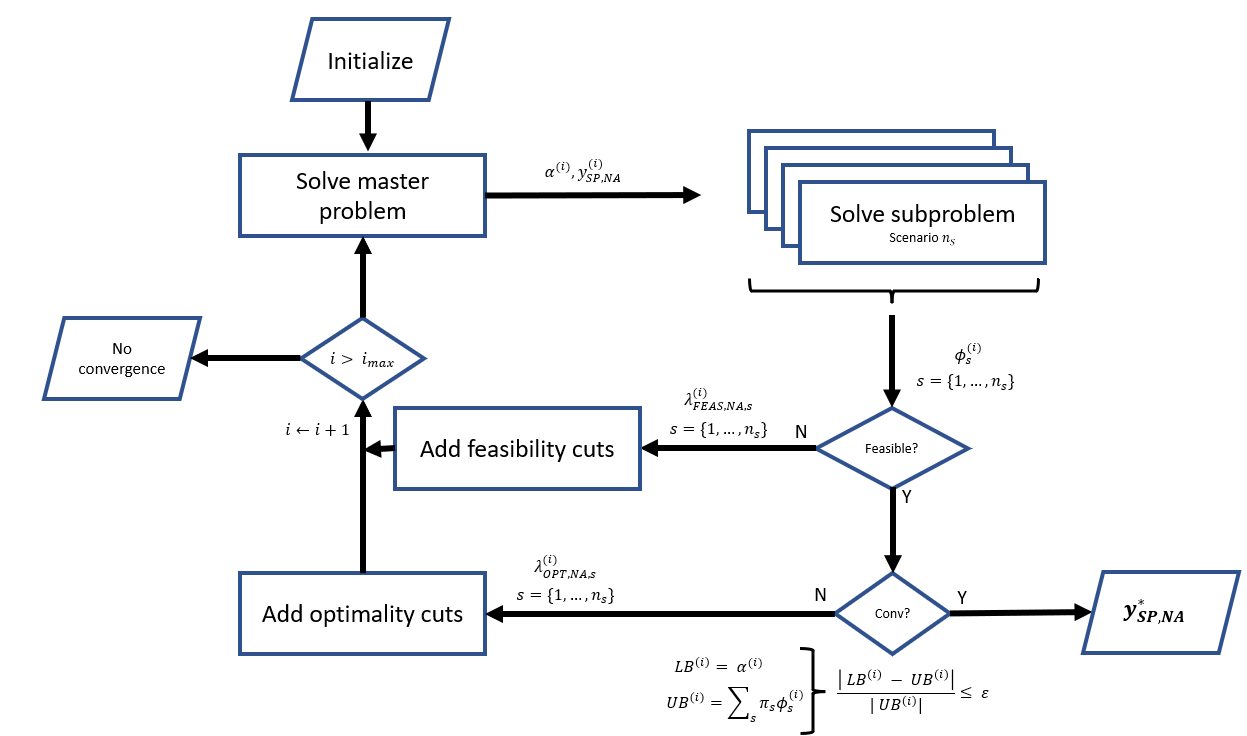
</div>

- Modeling Subproblem

- Modeling Master problem

<a id="sec3"></a>

# Checking the performance of the methods in terms of time vs. nScen

In [19]:
# testing the number of scenarios
nScenMax = 10 # 30

#preparing plot 
# --> monolithic vs. decomposed 
# solution time
solTimeTraj_s = Matrix{Float64}(undef,2,nScenMax - 1) 
# computed objective function
solObjTraj_s = Matrix{Float64}(undef,2,nScenMax - 1) 
# --> only decomposed
# max solution time over all scenarios 
solTimeMaxTraj_s = Vector{Float64}(undef,nScenMax - 1) 
# number of iterations
iterTraj_s = Vector{Float64}(undef,nScenMax - 1) 
# optimality gap
optGapTraj_s = Vector{Float64}(undef,nScenMax - 1) 
    
# building MPC's
# reactor 1 MPC: T1 <-> Q1
mpc1 = MPC_matrices(a1_hat,b1_hat,1,p,m,q,r[1])
# reactor 2 MPC: T2 <-> Qm
mpc2 = MPC_matrices(a2_hat,b2_hat,1,p,m,q,r[2])

for ss = 2:nScenMax
    display("evaluating $(ss) scenarios")

    #number os scenarios
    pTemp = LinRange(pNom - deltaPar,pNom + deltaPar, ss)
    pUnc = [pTemp'; Ua[2]*ones(1,ss)]
    
    # solving monolithical problem 
    sol_m_Dict = MS_CLDRTO(C0,T0,u0,xMPC0,pUnc,ss,solSS)

    # solving decomposed problem
    #sol_d_Dict = BENS_CLDRTO(xInit_0,uInit_0,nReactors,nScen,pScen,solNominal,opti)
    
    # for plotting
    #display("time M $(sol_m_Dict['t']) | time D $(sol_d_Dict['t'])")
    solTimeTraj_s[1,ss - 1] = sol_m_Dict['t']
    #solTimeTraj_s[2,ss] = sol_d_Dict['t']
    solObjTraj_s[1,ss - 1] = sol_m_Dict['ϕ']
    #solObjTraj_s[2,ss] = sol_d_Dict['ϕ']
    
    #solTimeMaxTraj_s[ss] = sol_d_Dict['m']
    #iterTraj_s[ss] = sol_d_Dict['i'] 
    #optGapTraj_s[ss] = sol_d_Dict['g']
end


"evaluating 2 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    11410
Number of nonzeros in inequality constraint Jacobian.:      280
Number of nonzeros in Lagrangian Hessian.............:     9200

Total number of variables............................:     2840
                     variables with only lower bounds:     1440
                variables with lower and upper bounds:      200
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2800
Total number of inequality constraints...............:      240
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 5.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 3 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    17155
Number of nonzeros in inequality constraint Jacobian.:      420
Number of nonzeros in Lagrangian Hessian.............:    13800

Total number of variables............................:     4260
                     variables with only lower bounds:     2160
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:     4220
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      360

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 3.33e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 4 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22900
Number of nonzeros in inequality constraint Jacobian.:      560
Number of nonzeros in Lagrangian Hessian.............:    18400

Total number of variables............................:     5680
                     variables with only lower bounds:     2880
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:     5640
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      480

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 2.50e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 5 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    28645
Number of nonzeros in inequality constraint Jacobian.:      700
Number of nonzeros in Lagrangian Hessian.............:    23000

Total number of variables............................:     7100
                     variables with only lower bounds:     3600
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:     7060
Total number of inequality constraints...............:      600
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      600

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 2.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 6 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    34390
Number of nonzeros in inequality constraint Jacobian.:      840
Number of nonzeros in Lagrangian Hessian.............:    27600

Total number of variables............................:     8520
                     variables with only lower bounds:     4320
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equality constraints.................:     8480
Total number of inequality constraints...............:      720
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      720

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 1.67e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 7 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    40135
Number of nonzeros in inequality constraint Jacobian.:      980
Number of nonzeros in Lagrangian Hessian.............:    32200

Total number of variables............................:     9940
                     variables with only lower bounds:     5040
                variables with lower and upper bounds:      700
                     variables with only upper bounds:        0
Total number of equality constraints.................:     9900
Total number of inequality constraints...............:      840
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      840

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 1.43e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 8 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    45880
Number of nonzeros in inequality constraint Jacobian.:     1120
Number of nonzeros in Lagrangian Hessian.............:    36800

Total number of variables............................:    11360
                     variables with only lower bounds:     5760
                variables with lower and upper bounds:      800
                     variables with only upper bounds:        0
Total number of equality constraints.................:    11320
Total number of inequality constraints...............:      960
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      960

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 1.25e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 9 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    51625
Number of nonzeros in inequality constraint Jacobian.:     1260
Number of nonzeros in Lagrangian Hessian.............:    41400

Total number of variables............................:    12780
                     variables with only lower bounds:     6480
                variables with lower and upper bounds:      900
                     variables with only upper bounds:        0
Total number of equality constraints.................:    12740
Total number of inequality constraints...............:     1080
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1080

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 1.11e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

"evaluating 10 scenarios"

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    57370
Number of nonzeros in inequality constraint Jacobian.:     1400
Number of nonzeros in Lagrangian Hessian.............:    46000

Total number of variables............................:    14200
                     variables with only lower bounds:     7200
                variables with lower and upper bounds:     1000
                     variables with only upper bounds:        0
Total number of equality constraints.................:    14160
Total number of inequality constraints...............:     1200
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -0.0000000e+00 7.70e+03 1.00e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

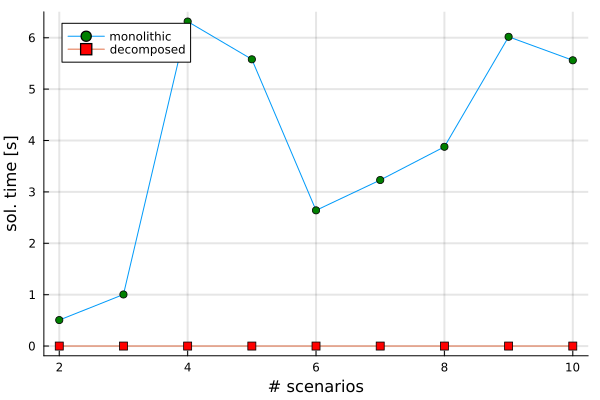

In [22]:
# solution time
p1 = plot(2:nScenMax,solTimeTraj_s[1,:],xlabel="# scenarios", ylabel="sol. time [s]",marker=:circle, markercolor = :green,label="monolithic")
p1 = plot!(2:nScenMax,solTimeTraj_s[2,:],marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p1)

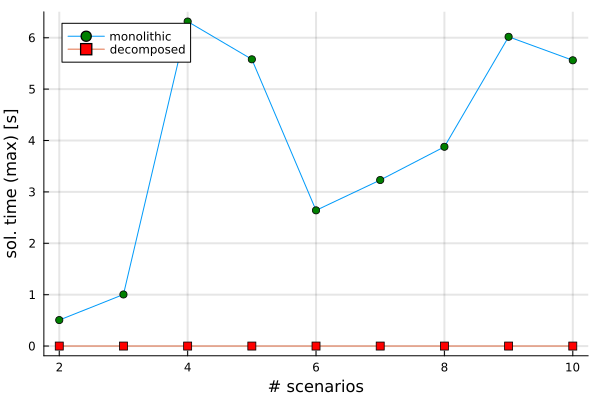

In [23]:
# solution time (parallel)
p2 = plot(2:nScenMax,solTimeTraj_s[1,:],xlabel="# scenarios", ylabel="sol. time (max) [s]",marker=:circle, markercolor = :green,label="monolithic")
p2 = plot!(2:nScenMax,solTimeMaxTraj_s,marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p2)

In [15]:
# number of iterations
function int_ticks(x; step=1) 
    imin = floor(Int, minimum(x))
    imax = ceil(Int, maximum(x))
    return range(imin, imax, step=step)
end

p3 = plot(1:nScenMax - 1,iterTraj_s,xlabel="# scenarios", ylabel="# iterations",marker=:square, markercolor = :red,label="decomposed",yticks=int_ticks(iterTraj_s; step=1),gridlinewidth=2)
display(p3)

LoadError: BoundsError: attempt to access 9-element Vector{Float64} at index [1:10]

In [16]:
# number of iterations
p4 = plot(1:nScenMax - 1,optGapTraj_s,yscale=:log10,xlabel="# scenarios", ylabel="opt gap.",marker=:square, markercolor = :red,label="decomposed",gridlinewidth=2)
display(p4)

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\MACC-Jose\.julia\packages\PlotUtils\bZEEj\src\ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\MACC-Jose\.julia\packages\PlotUtils\bZEEj\src\ticks.jl:191
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\MACC-Jose\.julia\packages\Plots\QZRtR\src\utils.jl:106


LoadError: BoundsError: attempt to access 9-element Vector{Float64} at index [1:10]

- Creating table to show the results

<a id="sec4"></a>

# Checking if trajectories match
- arbitrarily chosen number of scenarios and reactors